# Performance of Different Word Embeddings on Text Classification

## Compared among word2vec, TF-IDF weighted, GloVe and doc2vec

In [1]:
%load_ext autoreload
%autoreload 2

# Data libraries
import pandas as pd
import numpy as np
from numpy import random

# Word2Vec libraries
import gensim
from gensim.models import Doc2Vec
from gensim.models.doc2vec import TaggedDocument
from gensim.models.callbacks import CallbackAny2Vec
# Gensim utils for glove2word2vec
from gensim.test.utils import get_tmpfile, datapath
from gensim.models import KeyedVectors
from gensim.scripts.glove2word2vec import glove2word2vec

from collections import namedtuple, defaultdict
from sklearn.feature_extraction.text import TfidfVectorizer

# Classifiers that are going to be used
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

# Evaluation metrics and reports
from sklearn.metrics import f1_score, accuracy_score, classification_report, confusion_matrix

import timeit

# NLP/language/string Imports
import spacy
import en_core_web_lg
import nltk
from nltk.corpus import stopwords
import re
from bs4 import BeautifulSoup
import contractions

# Imports for files operations
import os
import pickle
from numpy import genfromtxt # In order to load a .csv file to a numpy array object

import warnings
warnings.simplefilter('ignore')
pd.set_option('max_colwidth',1000)

import matplotlib.pyplot as plt
%matplotlib inline


VECTOR_SIZE = 300

PICKLE_FILE = 'all_doc_news_300.pickle'
WORD2VEC_FILE = "word2vec_reviews_new_300.model"
MEAN_EMBEDDING_FILE = 'doc_vec_new_300.csv'
TFIDF_EMBEDDING_FILE = 'tfidf_doc_vec_new_300.csv'
GLOVE_EMBEDDING_FILE = 'glove_doc_vec_new_300.csv'
DOC2VEC_EMBEDDING_FILE = 'dm_doc_vec_new_300.csv'

random_state = 420

# Specify train/valid/test sizes
TEST_SIZE = 0.2
VALID_SIZE = 0.0

2021-10-31 09:56:22.401159: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-10-31 09:56:22.401181: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


# Abstract

## The Incentive

It's been a while not able to write new posts, so sad, but now finally I am back again to share some of the knowledge I've just acquired. This time is about NLP. 

As a fresh rookie in NLP, I'd like to play around and test out how different methods of creating doc vector perform on text classification. This post will be highly focused on feature engineering side, that is word vectorization, and less on modeling. Thus, without further due, let's get started.

## Brief Introduction

The word embeddings being investigated here are word2vec, TF-IDF weighted word2vec, pre-train GloVe word2vec and doc2vec. The packages needed are Gensim, Spacy and Scikit-Learn. Spacy is used in doc preprocessing, including stop word removal and custom token selection based on its part of speech. Gensim is heavily applied for training word2vec and doc2vec, and lastly, Scikit-Learn is for classifier building and training.

## Quick Summary

After a series of comparison on different word embedding/averaging methods, it turns out that custom-trained word embedding and its averaging method, either simple mean or TF-IDF weighted has the best performance, while on the contrary, GloVe word embedding or custom-trained Doc2vec perform slightly worse than the former word embedding.

Besides, even if we try to concatenate both word2vec and doc2vec as a whole feature set, it performs equally the same to just using averaging word embedding alone. In other words, no need to use both word2vec and doc2vec at the same time.


| WordEmbedding Method        | F1 Score - Training | F1 Score - Testing | Accuracy - Training | Accuracy - Testing |
| :---:                       | :---:               | :---:              | :---:               | :---:              |
| Mean Word2vec               | 0.82                | 0.81               | 0.82                | 0.81               |
| Tf-Idf Mean Word2vec        | 0.82                | 0.81               | 0.82                | 0.81               |
| GloVe Mean Word2vec         | 0.72                | 0.71               | 0.73                | 0.72               |
| PV-DM Doc2vec               | 0.79                | 0.78               | 0.79                | 0.78               |
| Tf-Idf Word2vec + Doc2vec   | 0.84                | 0.81               | 0.85                | 0.82               |


## Special Credits to the Following Posts and Authors

In creating my **python class object** used for text preprocessing, I referred from these well-written posts.

* The post ["Text Classification with Word2vec"](http://nadbordrozd.github.io/blog/2016/05/20/text-classification-with-word2vec/) by nadbor demos how to write your own class to compute average word embedding for doc, either simple averaging or TF-IDF weighted one.

* ["Multi-Class Text Classification Model Comparison and Selection"](https://towardsdatascience.com/multi-class-text-classification-model-comparison-and-selection-5eb066197568) by Susan Li teaches me how to write beautiful averaging function for word embedding.

* This tutorial ["Gensim Doc2vec Tutorial on the IMDB Sentiment Dataset"](https://github.com/RaRe-Technologies/gensim/blob/3c3506d51a2caf6b890de3b1b32a8b85f7566ca5/docs/notebooks/doc2vec-IMDB.ipynb) has step by step guidance on how to create doc2vec via Gensim.

* ["Distributed representations of sentences and documents"](https://blog.acolyer.org/2016/06/01/distributed-representations-of-sentences-and-documents/) by Le & Mikolov presents a clear and easy-to-understand explanation on what's going under doc2vec.

# Data Preparation

The dataset I am gonna use here is consumer complaints dataset on financial product/service as referred from [the post](https://towardsdatascience.com/multi-class-text-classification-with-doc2vec-logistic-regression-9da9947b43f4). The dataset is collected and published by [US GOV CFPB](https://catalog.data.gov/dataset/consumer-complaint-database), while we can also download the dataset from [Kaggle](https://www.kaggle.com/cfpb/us-consumer-finance-complaints).

The original dataset contains more than 500 thousands records, and columns include product, sub_product, issue, consumer_complaint_narrative, and company_response_to_consumer etc.. We will just use **product** as text label and **consumer_complaint_narrative** as text itself. After dropping rows of missing values on consumer complaint we are left with around 60 thousands records. In order to lessen the computing pressure, I will just experiment on the first 25 thousands records only.

## Read in Dataset

In [2]:
# Read in file.
df = pd.read_csv('IMDB Dataset.csv')

## Get Familiar with Dataset

In [3]:
# Get familiar with dataset.
df.shape

(50000, 2)

In [4]:
df.describe()

,review,sentiment
count,50000,50000
unique,49582,2
top,"Loved today's show!!! It was a variety and not solely cooking (which would have been great too). Very stimulating and captivating, always keeping the viewer peeking around the corner to see what was coming up next. She is as down to earth and as personable as you get, like one of us which made the show all the more enjoyable. Special guests, who are friends as well made for a nice surprise too. Loved the 'first' theme and that the audience was invited to play along too. I must admit I was shocked to see her come in under her time limits on a few things, but she did it and by golly I'll be writing those recipes down. Saving time in the kitchen means more time with family. Those who haven't tuned in yet, find out what channel and the time, I assure you that you won't be disappointed.",positive
freq,5,25000


In [5]:
# Select duplicate rows except first occurrence based on all columns
df = df.drop_duplicates()
df.describe()

,review,sentiment
count,49582,49582
unique,49582,2
top,"One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened with me.<br /><br />The first thing that struck me about Oz was its brutality and unflinching scenes of violence, which set in right from the word GO. Trust me, this is not a show for the faint hearted or timid. This show pulls no punches with regards to drugs, sex or violence. Its is hardcore, in the classic use of the word.<br /><br />It is called OZ as that is the nickname given to the Oswald Maximum Security State Penitentary. It focuses mainly on Emerald City, an experimental section of the prison where all the cells have glass fronts and face inwards, so privacy is not high on the agenda. Em City is home to many..Aryans, Muslims, gangstas, Latinos, Christians, Italians, Irish and more....so scuffles, death stares, dodgy dealings and shady agreements are never far away.<br /><br />I would say the main appeal of the show is due to the...",positive
freq,1,24884


## Filter on Text and Label

<mark>**Chart of Label Frequency**</mark>

Now, let's see how frequency distributed among each label.

In [6]:
# Distribution of target variable.
display(df['sentiment'].value_counts())

positive    24884
negative    24698
Name: sentiment, dtype: int64

In [7]:
import seaborn as sns

<mark>**Sample of Dataset**</mark>

In [8]:
print('Demo of review and its sentiment example...')
df.head()

Demo of review and its sentiment example...


,review,sentiment
0,"One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened with me.<br /><br />The first thing that struck me about Oz was its brutality and unflinching scenes of violence, which set in right from the word GO. Trust me, this is not a show for the faint hearted or timid. This show pulls no punches with regards to drugs, sex or violence. Its is hardcore, in the classic use of the word.<br /><br />It is called OZ as that is the nickname given to the Oswald Maximum Security State Penitentary. It focuses mainly on Emerald City, an experimental section of the prison where all the cells have glass fronts and face inwards, so privacy is not high on the agenda. Em City is home to many..Aryans, Muslims, gangstas, Latinos, Christians, Italians, Irish and more....so scuffles, death stares, dodgy dealings and shady agreements are never far away.<br /><br />I would say the main appeal of the show is due to the...",positive
1,"A wonderful little production. <br /><br />The filming technique is very unassuming- very old-time-BBC fashion and gives a comforting, and sometimes discomforting, sense of realism to the entire piece. <br /><br />The actors are extremely well chosen- Michael Sheen not only ""has got all the polari"" but he has all the voices down pat too! You can truly see the seamless editing guided by the references to Williams' diary entries, not only is it well worth the watching but it is a terrificly written and performed piece. A masterful production about one of the great master's of comedy and his life. <br /><br />The realism really comes home with the little things: the fantasy of the guard which, rather than use the traditional 'dream' techniques remains solid then disappears. It plays on our knowledge and our senses, particularly with the scenes concerning Orton and Halliwell and the sets (particularly of their flat with Halliwell's murals decorating every surface) are terribly well done.",positive
2,"I thought this was a wonderful way to spend time on a too hot summer weekend, sitting in the air conditioned theater and watching a light-hearted comedy. The plot is simplistic, but the dialogue is witty and the characters are likable (even the well bread suspected serial killer). While some may be disappointed when they realize this is not Match Point 2: Risk Addiction, I thought it was proof that Woody Allen is still fully in control of the style many of us have grown to love.<br /><br />This was the most I'd laughed at one of Woody's comedies in years (dare I say a decade?). While I've never been impressed with Scarlet Johanson, in this she managed to tone down her ""sexy"" image and jumped right into a average, but spirited young woman.<br /><br />This may not be the crown jewel of his career, but it was wittier than ""Devil Wears Prada"" and more interesting than ""Superman"" a great comedy to go see with friends.",positive
3,"Basically there's a family where a little boy (Jake) thinks there's a zombie in his closet & his parents are fighting all the time.<br /><br />This movie is slower than a soap opera... and suddenly, Jake decides to become Rambo and kill the zombie.<br /><br />OK, first of all when you're going to make a film you must Decide if its a thriller or a drama! As a drama the movie is watchable. Parents are divorcing & arguing like in real life. And then we have Jake with his closet which totally ruins all the film! I expected to see a BOOGEYMAN similar movie, and instead i watched a drama with some meaningless thriller spots.<br /><br />3 out of 10 just for the well playing parents & descent dialogs. As for the shots with Jake: just ignore them.",negative
4,"Petter Mattei's ""Love in the Time of Money"" is a visually stunning film to watch. Mr. Mattei offers us a vivid portrait about human relations. This is a movie that seems to be telling us what money, power and success do to people in the diffe

# Document Preprocessing

Now comes the first step -Doc Preprocessing. Before we create our own word embedding based on the input texts, we need to preprocess the text so that it complies with the input format as Gensim requires. It involves multiple steps starting from word tokenization, bi-gram detection, lemmatization etc..

Here, I wrote a python class called **DocProcess**. This class implements all the nitty-gritty jobs mentioned above for us under the hood, such as:

1. First, the class takes in a series of texts, then tokenizes the text and removes all punctuations.

2. It has the option build_bi, meaning whether to build up bi-gram, function adopted from Gensim. The default is False, if option build_bi is set to True, then the class will train a bi-gram detector and create bi-gram words for the text.

3. Now, all the processed tokens are concatenated back to form a sentence again.

4. The texts are tokenized once again, but this time, both **stop words** and **parts of speech** that are not allowed in the text will be removed and all tokens are **lemmatized**. These tokens are stored as `self.doc_words` - list of the tokens for each text(doc).

5. Finally, these `self.doc_words` are wrapped up into **TaggedDocument**, a object type in Gensim for later use in doc2vec training. It's stored in `self.tagdocs`.

In [9]:
nlp = en_core_web_lg.load()

nltk.download('stopwords')


stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /home/nick/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [10]:
#stop_words.remove('not')

In [11]:
print(stop_words)

{"don't", 'so', 'while', 'for', 'once', 'are', "it's", 'after', 'been', 'how', 'didn', 'yourselves', 'of', 't', 'into', "she's", "doesn't", "shan't", 'hadn', 'over', 'theirs', 'through', 'these', 'did', 'ourselves', 'down', 'other', "you'd", 'some', 'y', 'before', 'own', 'who', "won't", 've', 'our', 'all', 'was', 'had', 'both', 'mustn', 'she', 'up', 'doing', 'can', 'shan', 'his', 'we', "hadn't", "should've", 'myself', 'wouldn', 'your', 'those', 'couldn', 'being', 'itself', 'themselves', 'does', 'me', 'don', "aren't", 'my', 'then', 'with', 'such', 'only', 'mightn', 'won', "weren't", "couldn't", 'o', 'needn', 'it', 'that', 'the', 'against', 'hasn', 'more', 'am', 'will', 'ours', 'hers', 'be', 'and', 'each', 'out', 'is', 'because', 'below', 're', 'which', 'isn', 'ain', 'if', 'an', 'he', "mightn't", 'but', 'm', 'you', 'have', 'll', 'why', "isn't", "needn't", 'at', 'most', 'than', 'him', 'to', 'until', 'where', 'too', 'has', "mustn't", 'between', 'wasn', 'any', 'further', 'on', 'here', 'from

There are 190 reviews which include atleast one url


Ttest_indResult(statistic=1.4024737926809745, pvalue=0.1607801273205851)

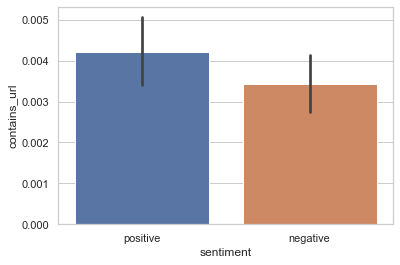

In [12]:
import re

def check_url(text):

# Regular expression for url

    re_equ = r"(?i)\b((?:https?://|www\d{0,3}[.]|[a-z0-9.\-]+[.][a-z]{2,4}/)(?:[^\s()<>]+|\(([^\s()<>]+|(\([^\s()<>]+\)))*\))+(?:\(([^\s()<>]+|(\([^\s()<>]+\)))*\)|[^\s`!()\[\]{};:'\".,<>?«»“”‘’]))"

    ck_url = re.findall(re_equ, text)

    if ck_url:
        return 1
    else:
        return 0
       

df_temp = df.copy()
df_temp['contains_url'] = df_temp['review'].apply(check_url)

print("There are", sum(df_temp['contains_url']), "reviews which include atleast one url")

sns.set_theme(style="whitegrid")
tips = sns.load_dataset("tips")
ax = sns.barplot(x="sentiment", y="contains_url", data=df_temp)

x_pos = df_temp[df_temp['sentiment'] == 'positive']['contains_url']
x_neg = df_temp[df_temp['sentiment'] == 'negative']['contains_url']


from scipy import stats

# two-side t-test with sample with identical means
stats.ttest_ind(x_pos, x_neg,equal_var=False)
# The t-test shows that a p-value larger than a chosen threshold (e.g. 5% or 1%) indicates that our observation is not so unlikely to have occurred by chance. Therefore, we do not reject the null hypothesis of equal population means, and therefore since only a few reviews include links-urls it is not beneficial to keep a token for the urls in the tokenization process. 
# Thus, all urls will be thrown away during the pre-processing phase.

The t-test shows that a p-value larger than a chosen threshold (e.g. 5% or 1%) indicates that our observation is not so unlikely to have occurred by chance. Therefore, we do not reject the null hypothesis of equal population means, and therefore since only a few reviews include links-urls it is not beneficial to keep a token for the urls in the tokenization process. Thus, all urls will be thrown away during the pre-processing phase.

In [13]:
def expand_contractions(text):
	return contractions.fix(text)

class DocPreprocess(object):

	def __init__(self,
				 nlp,
				 stop_words,
				 docs,
				 labels,
				 build_bi=False,
				 min_count=5,
				 threshold=10,
				 allowed_postags=['ADV', 'VERB', 'ADJ', 'NOUN', 'PROPN', 'NUM']):
# 				 not_allowed_postags = ['AUX', 'SCONJ', 'PUNCT', 'X', 'SYM'] # There are more

		self.nlp = nlp  # spacy nlp object
		self.stop_words = stop_words  # spacy.lang.en.stop_words.STOP_WORDS
		self.docs = docs  # docs must be list or series of documents
		self.labels = labels # labels must be list or or numpy array or series of labels
		self.doc_ids = np.arange(len(docs))
		self.parsed_docs = [BeautifulSoup(doc, "html.parser").get_text() for doc in self.docs] # Removes html tags
		self.parsed_docs = [re.sub(r'http\S+', '', doc) for doc in self.parsed_docs] #remove urls
		self.parsed_docs = [re.sub(r'www.\S+', '', doc) for doc in self.parsed_docs] #remove urls starting with 'www.'
		self.parsed_docs = [expand_contractions(doc) for doc in self.parsed_docs] # Expanding chatwords and contracts clearing contractions
		# This lowercases, tokenizes and remove words that their len is greater than 15 or lower than 2 (e.g. 'I')
		self.simple_doc_tokens = [gensim.utils.simple_preprocess(doc, deacc=True) for doc in self.parsed_docs]

		if build_bi:
			self.bi_detector = self.build_bi_detect(self.simple_doc_tokens, min_count=min_count, threshold=threshold)
			self.new_docs = self.make_bigram_doc(self.bi_detector, self.simple_doc_tokens)
		else:
			self.new_docs = self.make_simple_doc(self.simple_doc_tokens)
		self.doc_words = [self.lemmatize(doc, allowed_postags=allowed_postags) for doc in self.new_docs]
		self.tagdocs = [TaggedDocument(words=words, tags=[tag]) for words, tag in zip(self.doc_words, self.doc_ids)]

	def build_bi_detect(self, simple_doc_tokens, min_count, threshold):
		bi_ = gensim.models.phrases.Phrases(simple_doc_tokens, min_count=min_count, threshold=threshold)
		bi_detector = gensim.models.phrases.Phraser(bi_)  # wrapper enhance efficiency
		return bi_detector

    
	def make_simple_doc(self, simple_doc_tokens):
		simple_docs = []
		for doc_tokens in simple_doc_tokens:
			simple = " ".join(doc_tokens)  # concatenate back to a sentence
			simple_docs.append(simple)
		return simple_docs
    

	def make_bigram_doc(self, bi_detector, simple_doc_tokens):
		bi_doc_tokens = [bi_detector[doc_tokens] for doc_tokens in simple_doc_tokens]
		bi_docs = []
		for bi_tokens in bi_doc_tokens:
			bi_doc = " ".join(bi_tokens)  # concatenate back to a sentence
			bi_docs.append(bi_doc)
		return bi_docs


	def lemmatize(self, doc, allowed_postags):
		"""
		Lemmatize words and remove stop_words.
		:param doc: text
		:param allowed_postags: list of pos tags
		:return:
			list of tokens
		"""
		doc = self.nlp(doc)
		tokens = [token.lemma_ for token in doc if (token.pos_ in allowed_postags) and (token.text not in self.stop_words)]
		return tokens

if not os.path.exists('./' + PICKLE_FILE):
    preprocessed_docs = DocPreprocess(nlp, stop_words, df['review'], df['sentiment'], build_bi=True)
else:
    print("Pickle with the documents-reviews already exists")

Pickle with the documents-reviews already exists


In [14]:
# Saving to pickle

if os.path.exists('./' + PICKLE_FILE):
    # Read the saved docs as a pickle.
    print('Reading documents from pickle')
    with open(os.path.join(PICKLE_FILE), 'rb') as f:
        preprocessed_docs = pickle.load(f)
else:  
    # Save preprocessed_docs as a pickle.
    print('Saving documents as a pickle')
    with open(os.path.join(PICKLE_FILE), 'wb') as f:
        pickle.dump(preprocessed_docs, f, pickle.HIGHEST_PROTOCOL)

Reading documents from pickle


## Struacture of Preprocessed Docs

In [15]:
# Type of object preprocessed documents
type(preprocessed_docs)

__main__.DocPreprocess

In [16]:
len(preprocessed_docs.tagdocs)

49582

In [17]:
# Example of a document
doc_id = 0 # e.g. id = 3 

print('A tagged document object: ')
print(preprocessed_docs.tagdocs[doc_id], '\n')

print('Words of the document:')
print(preprocessed_docs.doc_words[doc_id], '\n')

print('Sentiment-label of tagged document: ')
print(preprocessed_docs.labels.iloc[doc_id], '\n')

A tagged document object: 
TaggedDocument(['one', 'other_reviewer', 'mention', 'after_watche', 'episode', 'hook', 'right', 'happen', 'first', 'thing', 'struck_me', 'oz', 'brutality', 'unflinching', 'scene', 'violence', 'set', 'right', 'word', 'go', 'trust_me', 'show', 'faint_hearte', 'timid', 'show', 'pull', 'no_punche', 'regard', 'drug', 'sex', 'violence', 'hardcore', 'classic', 'use', 'word', 'call', 'oz', 'nickname', 'give', 'oswald', 'maximum_security', 'state', 'penitentary', 'focuses_mainly', 'experimental', 'section', 'prison', 'cell', 'glass', 'front', 'face', 'inwards', 'privacy', 'high', 'agenda', 'city', 'home', 'many', 'aryans', 'muslims', 'gangstas', 'latinos', 'christians', 'italians', 'irish', 'scuffle', 'death', 'stare', 'dodgy', 'dealing', 'shady', 'agreement', 'never', 'far_away', 'say', 'main', 'appeal', 'show', 'due', 'fact', 'go', 'show', 'dare', 'forget', 'pretty', 'picture', 'paint', 'mainstream_audience', 'forget', 'charm', 'forget', 'romance', 'mess', 'first', 

# Building the basic bow and TFidf models

In [18]:
# from sklearn.model_selection import train_test_split
# from sklearn.preprocessing import LabelBinarizer


# # Getting the features (tokens-words/ngrams)
# X = preprocessed_docs.doc_words

# # Labeling the sentient data
# y = LabelBinarizer().fit_transform(df['sentiment']).ravel()

# # Notice how we used stratification over the train-test split
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=random_state, stratify=y)

## Bow model

In [19]:
# # Disabling lowercase since the data was already lowercased
# # Using deaful utf-8 encoding as it was mentioned in the lectures
# from sklearn.feature_extraction.text import CountVectorizer
# vectorizer = CountVectorizer(analyzer=lambda x: x, lowercase=False, encoding='utf-8')

# X_train_bow = vectorizer.fit_transform(X_train)
# print('X_train_bow:', X_train_bow.shape)
# X_test_bow = vectorizer.transform(X_test)
# print('X_test_bow:', X_test_bow.shape)

In [20]:
# from sklearn.linear_model import LogisticRegression

# # Training the model
# lr_2 = LogisticRegression(penalty='l2', max_iter=500, random_state=random_state,verbose=10)

# # Fitting the model for TF-IDFfrom sklearn.linear_model import LogisticRegression
# from sklearn.metrics import accuracy_score

# # Training the model
# lr_1 = LogisticRegression(penalty='l2', max_iter=500, random_state=random_state)

# # Fitting the model for Bag of words
# lr_bow = lr_1.fit(X_train_bow, y_train)
# # Predicting the test data for Bag of words
# lr_bow_predict = lr_1.predict(X_test_bow)
# # Accuracy score for bag of word
# lr_bow_score = accuracy_score(y_test,lr_bow_predict)
# print("lr_bow_score :", lr_bow_score)

## TF-IDF model

In [21]:
# # Disabling lowercase since the data was already lowercased
# # Using deaful utf-8 encoding as it was mentioned in the lectures
# from sklearn.feature_extraction.text import TfidfVectorizer
# vectorizer = TfidfVectorizer(analyzer=lambda x: x, lowercase=False, encoding='utf-8')

# X_train_tfidf = vectorizer.fit_transform(X_train)
# print('X_train_tfidf:', X_train_tfidf.shape)
# X_test_tfidf= vectorizer.transform(X_test)
# print('X_test_tfidf:', X_test_tfidf.shape)

In [22]:
# from sklearn.linear_model import LogisticRegression

# # Training the model
# lr_2 = LogisticRegression(penalty='l2', max_iter=500, random_state=random_state,verbose=10)

# # Fitting the model for TF-IDFfrom sklearn.linear_model import LogisticRegression
# from sklearn.metrics import accuracy_score

# # Training the model
# lr_1 = LogisticRegression(penalty='l2', max_iter=500, random_state=random_state)

# # Fitting the model for tfidf
# lr_tfidf = lr_1.fit(X_train_tfidf, y_train)
# # Predicting the test data for tf-idf
# lr_tfidf_predict = lr_1.predict(X_test_tfidf)
# # Accuracy score for tfidf
# lr_tfidf_score = accuracy_score(y_test,lr_tfidf_predict)
# print("lr_tfidf_score :", lr_tfidf_score)

# Build up Word Model - Word2vec

Since the text are properly processed, we're ready to train our word2vec via Gensim. Here I chose the dimension size 100 for each word embedding and window size of 5. The training iterates for 100 times.

In [23]:
import multiprocessing
import sys
from gensim.models.word2vec import Word2Vec

core_workers = multiprocessing.cpu_count() - 1 # Leave one core out
print('Number of cpu cores to work: {}'.format(core_workers))
assert gensim.models.doc2vec.FAST_VERSION > -1, "This will be very slow otherwise."

Number of cpu cores to work: 7


In [24]:
class callback(CallbackAny2Vec):
    '''Callback to print loss after every epoch.'''

    def __init__(self):
        self.epoch = 0
        self.loss_to_be_subed = 0
        self.start = timeit.default_timer()
        self.stop = None

    def on_epoch_end(self, model):
        loss = model.get_latest_training_loss()
        loss_now = loss - self.loss_to_be_subed
        self.loss_to_be_subed = loss
        self.stop = timeit.default_timer()
        print('Loss after epoch {}: {},  Epoch time: {} seconds'.format(self.epoch, loss_now, str(self.stop - self.start)))
        self.epoch += 1
        self.start = timeit.default_timer()


if not os.path.exists('./' + WORD2VEC_FILE):
    word_model = Word2Vec(preprocessed_docs.doc_words, min_count=2, vector_size=VECTOR_SIZE, window=5, workers=core_workers, epochs=175, 
                      compute_loss=True, callbacks=[callback()])
else:
    print("File with the word2vec_reviews model already exists")

File with the word2vec_reviews model already exists


In [25]:
# Saving or loading word2vec model to/from a file

if os.path.exists('./' + WORD2VEC_FILE):
    # Read the saved model
    print('Reading model from file')
    try:
        word_model = gensim.models.Word2Vec.load(WORD2VEC_FILE)
        print('Done')
    except Exception as e:    
        print('Could not load file', e)
else:  
    # Save word2vec model object as a model file.
    print('Saving documents as a pickle')
    try:
        word_model.save(WORD2VEC_FILE)
        print('Done')
    except Exception as e:
        print('Could not save file', e)
        

Reading model from file
Done


# Averaging Word Embedding for Each Doc

OK! Now we have the word embedding at hand, we'll be using the word embedding to compute for representative vector for whole text. It then serves as feature input for text classification model. There are various ways to come up with doc vector. First, let's start with the simple one.

## Simple Averaging on Word Embedding

This is a rather straightforward method. It directly averages all word embedding occurred in the text. Here I adapted the code from these two posts [2](http://nadbordrozd.github.io/blog/2016/05/20/text-classification-with-word2vec/), [3](https://towardsdatascience.com/multi-class-text-classification-model-comparison-and-selection-5eb066197568) and created the python class **MeanWordEmbeddingVectorizer**.

In [26]:
class MeanEmbeddingVectorizer(object):

	def __init__(self, word_model):
		self.word_model = word_model
		self.vector_size = word_model.wv.vector_size

	def fit(self):  # comply with scikit-learn transformer requirement
		return self

	def transform(self, docs):  # comply with scikit-learn transformer requirement
		doc_word_vector = self.word_average_list(docs)
		return doc_word_vector

	def word_average(self, sent):
		"""
		Compute average word vector for a single doc/sentence.
		:param sent: list of sentence tokens
		:return:
			mean: float of averaging word vectors
		"""
		mean = []
		for word in sent:
			if word in self.word_model.wv:
				mean.append(self.word_model.wv.get_vector(word))

		if not mean:  # empty words
			# If a text is empty, return a vector of zeros.
			logging.warning("cannot compute average owing to no vector for {}".format(sent))
			return np.zeros(self.vector_size)
		else:
			mean = np.array(mean).mean(axis=0)
			return mean


	def word_average_list(self, docs):
		"""
		Compute average word vector for multiple docs, where docs had been tokenized.
		:param docs: list of sentence in list of separated tokens
		:return:
			array of average word vector in shape (len(docs),)
		"""
		return np.vstack([self.word_average(sent) for sent in docs])
    
    
if not os.path.exists('./' + MEAN_EMBEDDING_FILE):
    mean_vec_tr = MeanEmbeddingVectorizer(word_model)
    doc_vec = mean_vec_tr.transform(preprocessed_docs.doc_words)
else:
    print("File with the average word2vec model already exists")

File with the average word2vec model already exists


In [27]:
# Saving or loading averaging word2vec model to/from a file
if os.path.exists('./' + MEAN_EMBEDDING_FILE):
    # Read the saved model from a csv file
    print('Reading model from file')
    try:
        doc_vec = genfromtxt(MEAN_EMBEDDING_FILE, delimiter=',')
        print('Done')
    except Exception as e:    
        print('Could not load file', e)
else:  
    # Save model object as a csv file
    print('Saving documents as a pickle')
    try:
        np.savetxt(os.path.join(MEAN_EMBEDDING_FILE), doc_vec, delimiter=',')
        print('Done')
    except Exception as e:
        print('Could not save file', e)

print('Shape of word-mean doc2vec: ')
display(doc_vec.shape)

Reading model from file
Done
Shape of word-mean doc2vec: 


(49582, 300)

## TF-IDF Weighted Averaging on Word Embedding

Not just satisfied with simple averaging? We can further adopt TF-IDF as weights for each word embedding. This will amplify the role of significant word in computing doc vector. Here, the whole process is implemented under class **TfidfEmbeddingVectorizer**. Again, the code is adapted from the same post source.

One thing worth noted is that, the Term Frequency has already been considered when we conduct averaging over the text, but not Inverse Document Frequency, thus the weight literally being the IDF, and the unseen word is assigned the max IDF in default setting.

And the other thing to note is that we need to fit the class with tokens first, for it must loop through all the words before hand in order to compute IDF.

In [28]:
class TfidfEmbeddingVectorizer(object):

	def __init__(self, word_model):

		self.word_model = word_model
		self.word_idf_weight = None
		self.vector_size = word_model.wv.vector_size

	def fit(self, docs):  # comply with scikit-learn transformer requirement
		"""
		Fit in a list of docs, which had been preprocessed and tokenized,
		such as word bi-grammed, stop-words removed, lemmatized, part of speech filtered.
		Then build up a tfidf model to compute each word's idf as its weight.
		Noted that tf weight is already involved when constructing average word vectors, and thus omitted.
		:param
			pre_processed_docs: list of docs, which are tokenized
		:return:
			self
		"""

		text_docs = []
		for doc in docs:
			text_docs.append(" ".join(doc))

		tfidf = TfidfVectorizer()
		tfidf.fit(text_docs)  # must be list of text string

		# if a word was never seen - it must be at least as infrequent
		# as any of the known words - so the default idf is the max of
		# known idf's
		max_idf = max(tfidf.idf_)  # used as default value for defaultdict
		self.word_idf_weight = defaultdict(lambda: max_idf,
										   [(word, tfidf.idf_[i]) for word, i in tfidf.vocabulary_.items()])
		return self


	def transform(self, docs):  # comply with scikit-learn transformer requirement
		doc_word_vector = self.word_average_list(docs)
		return doc_word_vector


	def word_average(self, sent):
		"""
		Compute average word vector for a single doc/sentence.
		:param sent: list of sentence tokens
		:return:
			mean: float of averaging word vectors
		"""

		mean = []
		for word in sent:
			if word in self.word_model.wv.index_to_key:
				mean.append(self.word_model.wv.get_vector(word) * self.word_idf_weight[word])  # idf weighted

		if not mean:  # empty words
			# If a text is empty, return a vector of zeros.
			logging.warning("cannot compute average owing to no vector for {}".format(sent))
			return np.zeros(self.vector_size)
		else:
			mean = np.array(mean).mean(axis=0)
			return mean


	def word_average_list(self, docs):
		"""
		Compute average word vector for multiple docs, where docs had been tokenized.
		:param docs: list of sentence in list of separated tokens
		:return:
			array of average word vector in shape (len(docs),)
		"""
		return np.vstack([self.word_average(sent) for sent in docs])

if not os.path.exists('./' + TFIDF_EMBEDDING_FILE):
    tfidf_vec_tr = TfidfEmbeddingVectorizer(word_model)
    tfidf_vec_tr.fit(preprocessed_docs.doc_words)  # fit tfidf model first
    tfidf_doc_vec = tfidf_vec_tr.transform(preprocessed_docs.doc_words)
else:
    print("File with the tf-idf word2vec model already exists")

File with the tf-idf word2vec model already exists


In [29]:
# Saving or loading tf-idf word2vec model to/from a file
if os.path.exists('./' + TFIDF_EMBEDDING_FILE):
    # Read the saved model from a csv file
    print('Reading model from file')
    try:
        tfidf_doc_vec = genfromtxt(TFIDF_EMBEDDING_FILE, delimiter=',')
        print('Done')
    except Exception as e:    
        print('Could not load file', e)
else:  
    # Save model object as a csv file
    print('Saving documents as a pickle')
    try:
        np.savetxt(os.path.join(TFIDF_EMBEDDING_FILE), tfidf_doc_vec, delimiter=',')
        print('Done')
    except Exception as e:
        print('Could not save file', e)

print('Shape of tf-idf doc2vec: ')
display(tfidf_doc_vec.shape)

Reading model from file
Done
Shape of tf-idf doc2vec: 


(49582, 300)

## Leverage Pre-train GloVe Word Embedding

### Load in GloVe Vector

Let's include another option - leveraging the existing pre-trained word embedding and see how it performs in text classification. Here I follow up the instructions from [Stanford NLP course(CS224N) notebook](http://web.stanford.edu/class/cs224n/materials/Gensim%20word%20vector%20visualization.html), importing GloVe word embedding into Gensim to compute for averaging word embedding on text.

As a side note, I've also tried to apply Tf-IDF weighted method on GloVe vector, but found out that the result is basically the same as the ones from TF-IDF weighted averaging doc vector. Thus, I omit the demonstration and just include simple averaging on GloVe word vector here.

<mark>**APPENDIX: The explanation for logic behind loading pre-train word vector.**</mark>

The result of `datapath()` shows that Gensim will try to load in dataset from */Users/XXX/miniconda3/lib/python3.7/site-packages/gensim/test/test_data/*, and calls it `glove_vec_fi`.

It then uses `get_tmpfile()` to create a temporary file path to store the word2vec `tmp_word2vec_fi`, which is converted from `glove_vec_fi`.

At the final step, **KeyedVectors** then loads in the `tmp_word2vec_fi` as word model.

### Simple Averaging on GloVe Word Embedding

In [30]:
class MeanEmbeddingVectorizerGlove(MeanEmbeddingVectorizer):

	def __init__(self, word_model):
		self.word_model = word_model
		self.vector_size = word_model.vector_size

	def word_average(self, sent):
		"""
		Compute average word vector for a single doc/sentence.
		:param sent: list of sentence tokens
		:return:
			mean: float of averaging word vectors
		"""
		mean = []
		for word in sent:
			if word in self.word_model:
				mean.append(self.word_model.get_vector(word))

		if not mean:  # empty words
			# If a text is empty, return a vector of zeros.
			logging.warning("cannot compute average owing to no vector for {}".format(sent))
			return np.zeros(self.vector_size)
		else:
			mean = np.array(mean).mean(axis=0)
			return mean


# Load in GloVe vector.
if not os.path.exists('./' + GLOVE_EMBEDDING_FILE):
    glove_vec_fi = datapath('/home/nick/PycharmProjects/pythonProject/Homework/glove_emb/glove.6B.300d.txt')
    tmp_word2vec_fi = get_tmpfile('tmp_glove2word2vec.txt')

    glove2word2vec(glove_vec_fi, tmp_word2vec_fi)

    glove_word_model = KeyedVectors.load_word2vec_format(tmp_word2vec_fi)

    # Apply word averaging on GloVe word vector.
    glove_mean_vec_tr = MeanEmbeddingVectorizerGlove(glove_word_model)
    glove_doc_vec = glove_mean_vec_tr.transform(preprocessed_docs.doc_words)
else:
    print("File with the average word2vec GloVe model already exists")

File with the average word2vec GloVe model already exists


In [31]:
# Saving or loading averaging glove model to/from a file
if os.path.exists('./' + GLOVE_EMBEDDING_FILE):
    # Read the saved model from a csv file
    print('Reading model from file')
    try:
        glove_doc_vec = genfromtxt(GLOVE_EMBEDDING_FILE, delimiter=',')
        print('Done')
    except Exception as e:    
        print('Could not load file', e)
else:  
    # Save model object as a csv file
    print('Saving documents as a csv')
    try:
        np.savetxt(os.path.join(GLOVE_EMBEDDING_FILE), glove_doc_vec, delimiter=',')
        print('Done')
    except Exception as e:
        print('Could not save file', e)

print('Shape of mean glove_doc_vec: ')
display(glove_doc_vec.shape)

Reading model from file
Done
Shape of mean glove_doc_vec: 


(49582, 300)

In [32]:
# Examine if glove_doc_vec is equal to self-trained doc_vec.
print('Examine if glove_doc_vec is equal to self-trained doc_vec...')
glove_doc_vec[4] == doc_vec[4]

Examine if glove_doc_vec is equal to self-trained doc_vec...


array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False,

## Apply Doc2vec Training Directly

### PV-DM Model

Last but not least, we still have one more option - to directly train doc2vec, and no need to average all word embeddings. Here I chose **PV-DM model** to train my doc2vec.

The script is mostly referred from [Gensim tutorial](https://github.com/RaRe-Technologies/gensim/blob/3c3506d51a2caf6b890de3b1b32a8b85f7566ca5/docs/notebooks/doc2vec-IMDB.ipynb). And again, to save all the labor, I create a class **DocModel** for it. The class just needs to take in the **TaggedDocument** and then we call `self.custom_train()` method, the doc model will train itself.

<mark>**APPENDIX: Training with Fixed Learning Rate.**</mark>

It's said to achieve better result, but the statement is from a rather old-version gensim tutorial. I found no better training result out of using fixed learning rate. Instead, using the default one, which is also recommended by the new gensim document achieving better performance.

Excerpted from [Doc2vec tutorial](https://rare-technologies.com/doc2vec-tutorial/)

I have obtained better results by iterating over the data several times and either

1. randomizing the order of input sentences, or
2. manually controlling the learning rate over the course of several iterations.

In [33]:
class DocModel(object):

	def __init__(self, docs, **kwargs):
		"""
		:param docs: list of TaggedDocument
		:param kwargs: dictionary of (key,value) for Doc2Vec arguments
		"""
		self.model = Doc2Vec(**kwargs)
		self.docs = docs
		self.model.build_vocab([x for x in self.docs])

	def custom_train(self, fixed_lr=False, fixed_lr_epochs=None):
		"""
		Train Doc2Vec with two options, without fixed learning rate(recommended) or with fixed learning rate.
		Fixed learning rate also includes implementation of shuffling training dataset.
		:param fixed_lr: boolean
		:param fixed_lr_epochs: num of epochs for fixed lr training
		"""
		if not fixed_lr:
			self.model.train([x for x in self.docs],
							 total_examples=len(self.docs),
							 epochs=self.model.epochs)
		else:
			for _ in range(fixed_lr_epochs):
				self.model.train(utils.shuffle([x for x in self.docs]),
								 total_examples=len(self.docs),
								 epochs=1)
				self.model.alpha -= 0.002
				self.model.min_alpha = self.model.alpha  # fixed learning rate
                

In [34]:
if not os.path.exists('./' + DOC2VEC_EMBEDDING_FILE):

    # Instantiate a pv-dm model
    # Configure keyed arguments for Doc2Vec model.
    dm_args = {
        'dm': 1,
        'dm_mean': 1,
        'vector_size': 300, # VECTOR_SIZE IMPORTANT!!!
        'window': 5,
        'negative': 5,
        'hs': 0,
        'min_count': 2,
        'sample': 0,
        'workers': 7-1,
        'alpha': 0.025,
        'min_alpha': 0.025,
        'epochs': 175,
        'comment': 'alpha=0.025'
    }
    dm = DocModel(docs=preprocessed_docs.tagdocs, **dm_args)
    dm.custom_train()

    # Save doc2vec as feature dataframe.
    dm_doc_vec_ls = []
    for i in range(len(dm.model.docvecs)):
        dm_doc_vec_ls.append(dm.model.docvecs[i])

    dm_doc_vec = pd.DataFrame(dm_doc_vec_ls)
else:
    print("File with the doc2vec model already exists")

File with the doc2vec model already exists


In [35]:
# Saving or loading doc2vec model to/from a file
if os.path.exists('./' + DOC2VEC_EMBEDDING_FILE):
    # Read the saved model from a csv file
    print('Reading doc2vec model from file')
    try:
        dm_doc_vec = pd.read_csv(os.path.join(DOC2VEC_EMBEDDING_FILE), header=None)
        print('Done')
    except Exception as e:    
        print('Could not load file', e)
else:  
    # Save model object as a csv file
    print('Saving documents as a csv')
    try:
        dm_doc_vec.to_csv(os.path.join(DOC2VEC_EMBEDDING_FILE), index=False, header=False)
        print('Done')
    except Exception as e:
        print('Could not save file', e)

print('Shape of doc2vec: ')
display(dm_doc_vec.shape)

Reading doc2vec model from file
Done
Shape of doc2vec: 


(49582, 300)

# Prepare the Classification Model

Now, we've prepared all the necessary ingredients - different types of features. Let's experiment to observe their effect on classification performance. Here, I'll use **basic logistic model** as the base model and feed in different kind of features created earlier. Hence, to compare their effectiveness.

In addition to compare effects of each word embedding averaging method, I also try to **concatenate word2vec and doc2vec** together, and see if it can boost up the performance even more.

I used TF-IDF weighted word embedding and PV-DM doc2vec together. The result shows that it increases the accuracy on training dataset (perhaps a sign of over-fitting?), but not so significant improvement on testing dataset compared using TF-IDF word2vec alone.

In [36]:
# Get target_labels
target_labels = preprocessed_docs.labels

doc_vec = pd.read_csv(os.path.join('doc_vec_new_300.csv'), header=None)
tfidf_doc_vec = pd.read_csv(os.path.join('tfidf_doc_vec_new_300.csv'), header=None)
glove_doc_vec = pd.read_csv(os.path.join('glove_doc_vec_new_300.csv'), header=None)
dm_doc_vec = pd.read_csv(os.path.join('dm_doc_vec_new_300.csv'), header=None)

## Set up Model

In [37]:
# Classification via Logistic Model
# logistic = LogisticRegression(random_state=random_state, multi_class='multinomial', solver='saga')
logistic = LogisticRegression(penalty='l2', max_iter=500, random_state=random_state)

## Define Data Split Function

In [38]:
def init_data_splits(df, concat_dfs=None):
    if concat_dfs is not None:
        for concat_df in concat_dfs:
            df = pd.concat([df, concat_df], axis=1, ignore_index=True)
    
    # Prepare test dataset
    train_X, test_X, train_y, test_y = train_test_split(df,
                                                    target_labels,
                                                    test_size=TEST_SIZE,
                                                    random_state=random_state,
                                                    stratify=target_labels)
    # Prepare valid dataset
    if VALID_SIZE != 0:
        train_X, valid_X, train_y, valid_y = train_test_split(train_X,
                                                      train_y,
                                                      test_size=VALID_SIZE,
                                                      random_state=random_state,
                                                      stratify=train_y)
    
    print('Shape of train_X: {}'.format(train_X.shape))
    print('Shape of valid_X: {}'.format(valid_X.shape if 'valid_X' in vars() else (0,0)))
    print('Shape of text_X: {}'.format(test_X.shape))
    
    if VALID_SIZE != 0:
        return train_X, valid_X, test_X, train_y, valid_y, test_y
    else:
        return train_X, None, test_X, train_y, None, test_y

# Test Model

## Performance on Simple Averaging Word Vector

### Hyper-Parameters

In [39]:
model = logistic  # or choose sgd.
df = doc_vec

### Train

In [40]:
# __init_model_data_splits__
train_X, valid_X, test_X, train_y, valid_y, test_y = init_data_splits(df)

start = timeit.default_timer()
clf = model.fit(train_X, train_y)
stop = timeit.default_timer()
print('Training time{} seconds'.format(str(stop - start)))

Shape of train_X: (39665, 300)
Shape of valid_X: (0, 0)
Shape of text_X: (9917, 300)
Training time3.4918277529941406 seconds


### Test on Training Dataset

In [41]:
def evaluate_model(model, feature, label, label_names):
	pred = model.predict(feature)
	true = np.array(label)

	print('Score on dataset...\n')
	print('Confusion Matrix:\n', confusion_matrix(true, pred))
	print('\nClassification Report:\n', classification_report(true, pred, target_names=label_names))
	print('\naccuracy: {:.3f}'.format(accuracy_score(true, pred)))
	print('f1 score: {:.3f}'.format(f1_score(true, pred, average='weighted')))

	return pred, true

# Score on valid dataset.
print('Performance of Mean Word Vector on training dataset...')
_, _ = evaluate_model(clf, train_X, train_y, label_names=None)

Performance of Mean Word Vector on training dataset...
Score on dataset...

Confusion Matrix:
 [[17511  2247]
 [ 2115 17792]]

Classification Report:
               precision    recall  f1-score   support

    negative       0.89      0.89      0.89     19758
    positive       0.89      0.89      0.89     19907

    accuracy                           0.89     39665
   macro avg       0.89      0.89      0.89     39665
weighted avg       0.89      0.89      0.89     39665


accuracy: 0.890
f1 score: 0.890


### Test on Testing Dataset

In [42]:
# Score on test dataset.
print('Performance of Mean Word Vector on testing dataset...')
_, _ = evaluate_model(clf, test_X, test_y, label_names=None)

Performance of Mean Word Vector on testing dataset...
Score on dataset...

Confusion Matrix:
 [[4320  620]
 [ 529 4448]]

Classification Report:
               precision    recall  f1-score   support

    negative       0.89      0.87      0.88      4940
    positive       0.88      0.89      0.89      4977

    accuracy                           0.88      9917
   macro avg       0.88      0.88      0.88      9917
weighted avg       0.88      0.88      0.88      9917


accuracy: 0.884
f1 score: 0.884


## Performance on Tf-Idf Weighted Averaging Word Vector

### Hyper-Parameters

In [43]:
model = logistic  # or choose sgd.
df = tfidf_doc_vec

### Train

In [44]:
# __init_model_data_splits__
train_X, valid_X, test_X, train_y, valid_y, test_y = init_data_splits(df)

# Train model
start = timeit.default_timer()
clf = model.fit(train_X, train_y)
stop = timeit.default_timer()
print('Training time{} seconds'.format(str(stop - start)))

Shape of train_X: (39665, 300)
Shape of valid_X: (0, 0)
Shape of text_X: (9917, 300)
Training time2.4948012230015593 seconds


### Test on Training Dataset

In [45]:
# Score on valid dataset.
print('Performance of Tf-Idf Mean Word Vector on training dataset...')
_, _ = evaluate_model(clf, train_X, train_y, label_names=None)

Performance of Tf-Idf Mean Word Vector on training dataset...
Score on dataset...

Confusion Matrix:
 [[17466  2292]
 [ 2230 17677]]

Classification Report:
               precision    recall  f1-score   support

    negative       0.89      0.88      0.89     19758
    positive       0.89      0.89      0.89     19907

    accuracy                           0.89     39665
   macro avg       0.89      0.89      0.89     39665
weighted avg       0.89      0.89      0.89     39665


accuracy: 0.886
f1 score: 0.886


### Test on Testing Dataset

In [46]:
# Score on test dataset.
print('Performance of Tf-Idf Mean Word Vector on testing dataset...')
_, _ = evaluate_model(clf, test_X, test_y, label_names=None)

Performance of Tf-Idf Mean Word Vector on testing dataset...
Score on dataset...

Confusion Matrix:
 [[4303  637]
 [ 545 4432]]

Classification Report:
               precision    recall  f1-score   support

    negative       0.89      0.87      0.88      4940
    positive       0.87      0.89      0.88      4977

    accuracy                           0.88      9917
   macro avg       0.88      0.88      0.88      9917
weighted avg       0.88      0.88      0.88      9917


accuracy: 0.881
f1 score: 0.881


## Performance on Simple Averaging of GloVe Word Vector

### Hyper-Parameters

In [47]:
model = logistic  # or choose sgd.
df = glove_doc_vec

### Train

In [48]:
# __init_model_data_splits__
train_X, valid_X, test_X, train_y, valid_y, test_y = init_data_splits(df)

# Train model
start = timeit.default_timer()
clf = model.fit(train_X, train_y)
stop = timeit.default_timer()
print('Training time{} seconds'.format(str(stop - start)))

Shape of train_X: (39665, 300)
Shape of valid_X: (0, 0)
Shape of text_X: (9917, 300)
Training time5.586939211003482 seconds


### Test on Training Dataset

In [49]:
# Score on valid dataset.
print('Performance of GloVe Mean Word Vector on training dataset...')
_, _ = evaluate_model(clf, train_X, train_y, label_names=None)

Performance of GloVe Mean Word Vector on training dataset...
Score on dataset...

Confusion Matrix:
 [[16283  3475]
 [ 3339 16568]]

Classification Report:
               precision    recall  f1-score   support

    negative       0.83      0.82      0.83     19758
    positive       0.83      0.83      0.83     19907

    accuracy                           0.83     39665
   macro avg       0.83      0.83      0.83     39665
weighted avg       0.83      0.83      0.83     39665


accuracy: 0.828
f1 score: 0.828


### Test on Testing Dataset

In [50]:
# Score on test dataset.
print('Performance of GloVe Mean Word Vector on testing dataset...')
_, _ = evaluate_model(clf, test_X, test_y, label_names=None)

Performance of GloVe Mean Word Vector on testing dataset...
Score on dataset...

Confusion Matrix:
 [[4007  933]
 [ 829 4148]]

Classification Report:
               precision    recall  f1-score   support

    negative       0.83      0.81      0.82      4940
    positive       0.82      0.83      0.82      4977

    accuracy                           0.82      9917
   macro avg       0.82      0.82      0.82      9917
weighted avg       0.82      0.82      0.82      9917


accuracy: 0.822
f1 score: 0.822


## Performance on PV-DM Doc2vec

### Hyper-Parameters

In [51]:
model = logistic  # or choose sgd.
df = dm_doc_vec

### Train

In [52]:
# __init_model_data_splits__
train_X, valid_X, test_X, train_y, valid_y, test_y = init_data_splits(df)

# Train model
start = timeit.default_timer()
clf = model.fit(train_X, train_y)
stop = timeit.default_timer()
print('Training time{} seconds'.format(str(stop - start)))

Shape of train_X: (39665, 300)
Shape of valid_X: (0, 0)
Shape of text_X: (9917, 300)
Training time0.7693823680019705 seconds


### Test on Training Dataset

In [53]:
# Score on valid dataset.
print('Performance of Doc2vec on training dataset...')
_, _ = evaluate_model(clf, train_X, train_y, label_names=None)

Performance of Doc2vec on training dataset...
Score on dataset...

Confusion Matrix:
 [[17200  2558]
 [ 2458 17449]]

Classification Report:
               precision    recall  f1-score   support

    negative       0.87      0.87      0.87     19758
    positive       0.87      0.88      0.87     19907

    accuracy                           0.87     39665
   macro avg       0.87      0.87      0.87     39665
weighted avg       0.87      0.87      0.87     39665


accuracy: 0.874
f1 score: 0.874


### Test on Testing Dataset

In [54]:
# Score on test dataset.
print('Performance of Doc2vec on testing dataset...')
_, _ = evaluate_model(clf, test_X, test_y, label_names=None)

Performance of Doc2vec on testing dataset...
Score on dataset...

Confusion Matrix:
 [[4276  664]
 [ 638 4339]]

Classification Report:
               precision    recall  f1-score   support

    negative       0.87      0.87      0.87      4940
    positive       0.87      0.87      0.87      4977

    accuracy                           0.87      9917
   macro avg       0.87      0.87      0.87      9917
weighted avg       0.87      0.87      0.87      9917


accuracy: 0.869
f1 score: 0.869


## Performance on Tf-Idf and Doc2vec Concatenated Feature

### Hyper-Parameters

In [55]:
model = logistic  # or choose sgd.
df = tfidf_doc_vec
concat_dfs = [dm_doc_vec]

### Train

In [56]:
train_X, valid_X, test_X, train_y, valid_y, test_y = init_data_splits(df, concat_dfs=concat_dfs)

# Train model
start = timeit.default_timer()
clf = model.fit(train_X, train_y)
stop = timeit.default_timer()
print('Training time{} seconds'.format(str(stop - start)))

Shape of train_X: (39665, 600)
Shape of valid_X: (0, 0)
Shape of text_X: (9917, 600)
Training time9.371461502989405 seconds


### Test on Training Dataset

In [57]:
# Score on valid dataset.
print('Performance of Tf-Idf+Doc2vec on training dataset...')
_, _ = evaluate_model(clf, train_X, train_y, label_names=None)

Performance of Tf-Idf+Doc2vec on training dataset...
Score on dataset...

Confusion Matrix:
 [[17703  2055]
 [ 1980 17927]]

Classification Report:
               precision    recall  f1-score   support

    negative       0.90      0.90      0.90     19758
    positive       0.90      0.90      0.90     19907

    accuracy                           0.90     39665
   macro avg       0.90      0.90      0.90     39665
weighted avg       0.90      0.90      0.90     39665


accuracy: 0.898
f1 score: 0.898


### Test on Testing Dataset

In [58]:
# Score on test dataset.
print('Performance of Tf-Idf+Doc2vec on testing dataset...')
_, _ = evaluate_model(clf, test_X, test_y, label_names=None)

Performance of Tf-Idf+Doc2vec on testing dataset...
Score on dataset...

Confusion Matrix:
 [[4369  571]
 [ 502 4475]]

Classification Report:
               precision    recall  f1-score   support

    negative       0.90      0.88      0.89      4940
    positive       0.89      0.90      0.89      4977

    accuracy                           0.89      9917
   macro avg       0.89      0.89      0.89      9917
weighted avg       0.89      0.89      0.89      9917


accuracy: 0.892
f1 score: 0.892


## Performance on Tf-Idf  + Simple Averaging of GloVe Word Vector + Doc2vec Concatenated Feature???

# (Optional) Grid-Search for Best Hyper-Paremeters on Logistic

<mark>**NOTE:**</mark>

The `log_loss()` from sklearn expects to have predicted probs for each class. Thus, instead of simply using `clf.predict(X)`, we need to use `clf.predict_proba(X)` when computing for y_pred. In other words, if we want to use `GridSearchCV`, it's probabily best to directly specify scoring as **'neg_log_loss'**, instead of creating our own scoring func.

In [59]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, log_loss

logistic = LogisticRegression(random_state=random_state,
                              multi_class='multinomial',
                              solver='saga')

params_log = {"max_iter": [100, 200, 500], "C": [1, 2, 5]}


# Ref: https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter
# whether the python function returns a score 
# (greater_is_better=True, the default) or a loss (greater_is_better=False). 
# If a loss, the output of the python function is negated by the scorer object, 
# conforming to the cross validation convention that scorers return higher values for better models.
grid_log = GridSearchCV(logistic, param_grid=params_log, scoring='neg_log_loss', cv=5)

grid_log.fit(train_X, train_y)

print(
    "the best neg_log_loss of all model parameters' combination on model: {:.4f}"
    .format(grid_log.best_score_))

KeyboardInterrupt: 

In [ ]:
print("the parameter setting of optimized model: {}".format(
    grid_log.best_estimator_))

In [ ]:
print("the accuracy of the optimized model on testing dataset...")
_, _ = sk_evaluate(grid_log, test_X, test_y, label_names=None)

# (Optional) Grid-Search for Best Hyper-Parameters on SGD

<mark>**NOTE:**</mark>

The `roc_auc_score` only accepts **binary class**, thus if we have multiple classes, the `roc_auc_score` does not apply.

In [ ]:
from sklearn.metrics import roc_auc_score

sgd = SGDClassifier(loss='hinge', penality='l2', verbose=1, random_state=random_state)

params_sgd = {'learning_rate': ['adaptive', 'invscaling'], 
              'eta0': [1, 0.5, 0.1]}

grid_sgd = GridSearchCV(sgd, param_grid=params_sgd, scoring='accuracy', cv=5)

grid_sgd.fit(train_X, train_y)

print("the best auc of all model parameters' combination on model: {:.4f}".
      format(grid_sgd.best_score_))

In [ ]:
print("the parameter setting of optimized model: {}".format(
    grid_sgd.best_estimator_))

In [ ]:
print("the accuracy of the optimized model on testing dataset...")
_, _ = sk_evaluate(grid_sgd, test_X, test_y, label_names=None)